## tools

In [80]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys
import time
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [113]:
import xgboost as xgb

class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

class SklearnWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
    

class LightGBMRGWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

## downcast data

In [83]:
# train = pd.read_csv("./data/train.csv")
# test = pd.read_csv("./data/test.csv")

In [107]:
save_dataframe32("./bindata/train", train, keep=["ID", "target"])
save_dataframe32("./bindata/test", test, keep=["ID"])

In [108]:
train = load_dataframe32("./bindata/train")
test = load_dataframe32("./bindata/test")

In [111]:
train.head().T

,0,1,2,3,4
48df886f9,0,0,0,0,0
0deb4b6a8,0,0,0,0,0
34b15f335,0,0,0,0,0
a8cb14b00,0,0,0,0,0
2f0771a37,0,0,0,0,0
30347e683,0,0,0,0,0
d08d1fbe3,0,0,0,0,0
6ee66e115,0,0,0,0,0
20aa07010,0,2.2e+06,0,0,2e+06
dc5a8f1d8,0,0,0,0,0


In [112]:
test.head().T

,0,1,2,3,4
48df886f9,0,0,0,0,0
0deb4b6a8,0,0,0,0,0
34b15f335,0,0,0,0,0
a8cb14b00,0,0,0,0,0
2f0771a37,0,0,0,0,0
30347e683,0,0,0,0,0
d08d1fbe3,0,0,0,0,0
6ee66e115,0,0,0,0,0
20aa07010,0,0,0,0,0
dc5a8f1d8,0,0,0,0,0


## target distribution

In [247]:
def to_int(str16bit):
    try:
        result = 0
        for tok in str16bit:
            result *= 16
            result += "0123456789abcdef".index(tok)
    except:
        print("Error", str16bit)
    return result

def split_target_str(target_str):
    for i, tok in enumerate(reversed(target_str)):
        if tok not in "0.":
            break
    if i == 0:
        return (target_str, "")
    return (target_str[:-i], target_str[-i:])

In [106]:
# train_id = train[["ID", "target"]].copy()
# train_id.to_csv("./data/train_id.csv", index=False)

train_id = pd.read_csv("./data/train_id.csv")
train_id["int_id"] = train_id.ID.apply(to_int)
train_id["target_str"] = train_id.target.apply(str)
train_id["target_split"] = train_id.target_str.apply(split_target_str)
train_id["target_p0"] = train_id.target_split.apply(lambda x: x[0])
train_id["target_p1"] = train_id.target_split.apply(lambda x: x[1])
train_id["target_len0"] = train_id.target_split.apply(lambda x: len(x[0]))
train_id["target_len1"] = train_id.target_split.apply(lambda x: len(x[1]))
gc.collect()
train_id.head()

,ID,target,int_id,target_str,target_split,target_p0,target_p1,target_len0,target_len1
0,000d6aaf2,38000000.0,14068466,38000000.0,"(38, 000000.0)",38,000000.0,2,8
1,000fbd867,600000.0,16504935,600000.0,"(6, 00000.0)",6,00000.0,1,7
2,0027d6b71,10000000.0,41773937,10000000.0,"(1, 0000000.0)",1,0000000.0,1,9
3,0028cbf45,2000000.0,42778437,2000000.0,"(2, 000000.0)",2,000000.0,1,8
4,002a68644,14400000.0,44467780,14400000.0,"(144, 00000.0)",144,00000.0,3,7


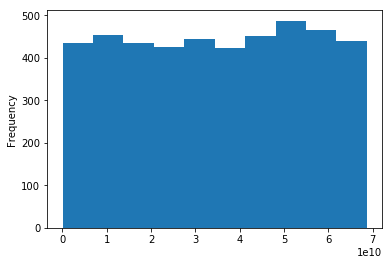

In [19]:
train_id.int_id.plot(kind="hist")
plt.show()

In [28]:
test_id = test[["ID"]].copy()
test_id["int_id"] = test_id.ID.apply(to_int)
test_id.head()

Error 0.0


,ID,int_id
0,000137c73,1277043
1,00021489f,2181279
2,0004d7953,5077331
3,00056a333,5677875
4,00056d8eb,5691627


In [31]:
test[test.ID == "0.0"]

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
49342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


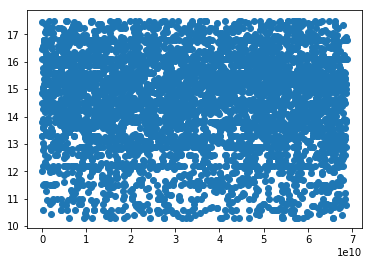

In [35]:
x = train_id.int_id.sort_values().values
y = np.log1p(train_id.sort_values("int_id").target.values)

plt.scatter(x, y)
plt.show()

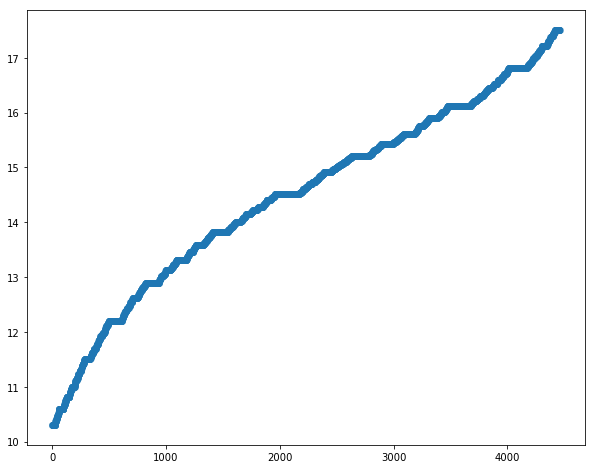

In [59]:
y = np.log1p(train_id.sort_values("target").target.values)
x = np.arange(len(y))

plt.figure(figsize=(10, 8))
plt.scatter(x, y, alpha=.5)
plt.show()

In [41]:
train_id.sort_values("target").target.value_counts().sort_values()

2968000.00       1
2580000.00       1
8057500.00       1
2842000.00       1
16200000.00      1
3266666.66       1
468571.42        1
5225000.00       1
920000.00        1
1186666.66       1
306000.00        1
1988666.66       1
12400000.00      1
858000.00        1
3627000.00       1
22200000.00      1
1879000.00       1
155000.00        1
6140000.00       1
5223600.00       1
342000.00        1
429000.00        1
2318000.00       1
8780000.00       1
1175000.00       1
5933333.34       1
237000.00        1
1945000.00       1
866000.00        1
153142.86        1
              ... 
15000000.00     21
60000.00        24
50000.00        25
30000.00        26
1800000.00      28
700000.00       28
1500000.00      30
7000000.00      31
1400000.00      31
1600000.00      33
300000.00       37
30000000.00     39
500000.00       39
1200000.00      39
40000000.00     40
40000.00        40
100000.00       44
800000.00       59
3000000.00      61
8000000.00      65
600000.00       84
6000000.00  

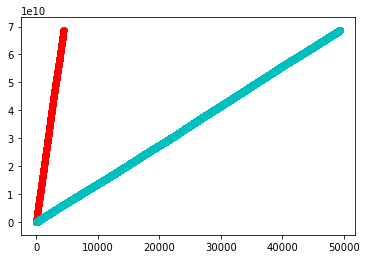

In [33]:
y = train_id.int_id.sort_values().values
x = np.arange(len(y))

plt.scatter(x, y, alpha=.5, c="r")

y_test = test_id.int_id.sort_values().values
x_test = np.arange(len(y_test))

plt.scatter(x_test, y_test, alpha=.5, c="c")

plt.show()

## my features

In [215]:
1e7
3e7
4e7

40000000.0

In [226]:
raw_features = [col_ for col_ in train.columns if col_ not in {"ID", "target"}]

train_cnt1e7 = train[raw_features].T.apply(lambda x: np.sum((x <= 1e7) & (x > 0)))
train_cnt3e7 = train[raw_features].T.apply(lambda x: np.sum((x <= 3e7) & (x > 1e7)))
train_cnt4e7 = train[raw_features].T.apply(lambda x: np.sum((x <= 4e7) & (x > 3e7)))
train_cnt5e7 = train[raw_features].T.apply(lambda x: np.sum(x > 5e7))

In [244]:
train_1div3 = train_cnt3e7 / (train_cnt1e7 + 1)
train_3div4 = train_cnt4e7 / (train_cnt3e7 + 1)
train_4div5 = train_cnt5e7 / (train_cnt4e7 + 1)

train_1mult3 = train_cnt3e7 * train_cnt1e7
train_3mult4 = train_cnt4e7 * train_cnt3e7
train_4mult5 = train_cnt5e7 * train_cnt4e7

In [227]:
train.shape

(4459, 4993)

In [236]:
np.log1p

<ufunc 'log1p'>

(4459,) (4459,)
(-0.11901663991759417, 1.541791642632588e-15)


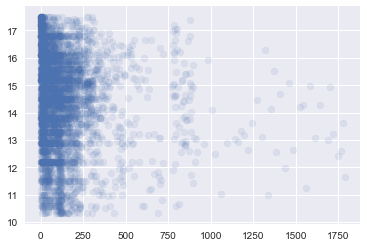

(4459,) (4459,)
(0.18532876249660882, 9.567832549920392e-36)


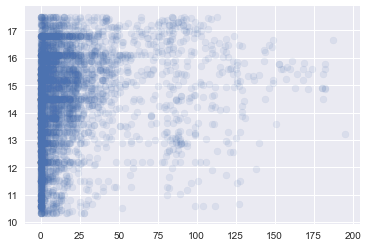

(4459,) (4459,)
(0.1686483517544958, 8.335868562287311e-30)


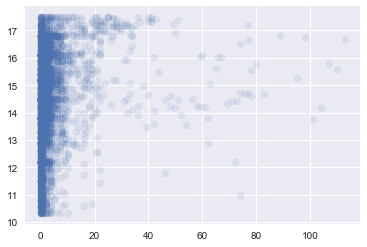

(4459,) (4459,)
(0.176187606003477, 2.0367841557219047e-32)


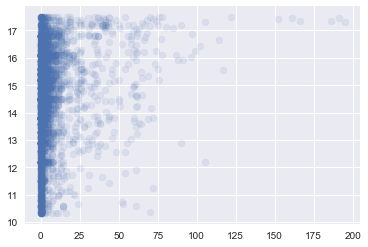

(4459,) (4459,)
(0.2102634781575837, 9.763429097327168e-46)


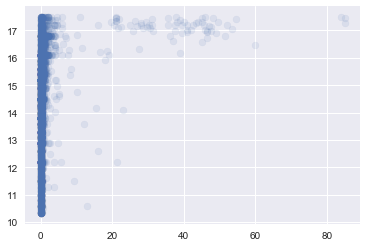

(4459,) (4459,)
(0.02548254759509767, 0.08886503709352135)


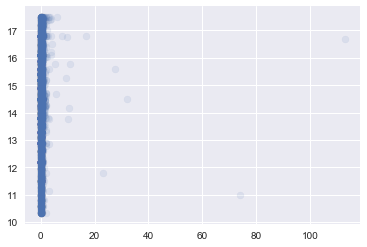

(4459,) (4459,)
(0.05170429059135479, 0.0005524711177673225)


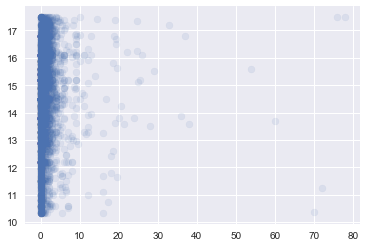

(4459,) (4459,)
(-0.0009141617416115793, 0.9513379224312505)


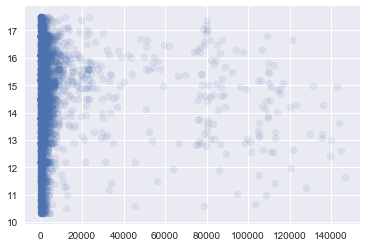

(4459,) (4459,)
(0.1652696199209765, 1.129370952147952e-28)


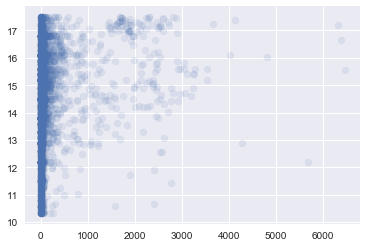

(4459,) (4459,)
(0.12063302248563636, 6.338315483131026e-16)


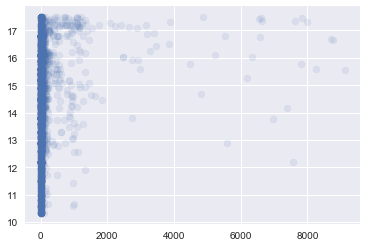

In [245]:
y = train.target.values
for x in (
    train_cnt1e7,
    train_cnt3e7,
    train_cnt4e7,
    train_cnt5e7,
    train_1div3,
    train_3div4,
    train_4div5,
    train_1mult3,
    train_3mult4,
    train_4mult5
):
    print(x.shape, y.shape)
    y_log1p = np.log1p(y.astype(np.float32))
    print(pearsonr(x, y_log1p))
    plt.scatter(x, y_log1p, alpha=.1)
    plt.show()

In [193]:
train.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466,ID,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000d6aaf2,3.8e+07
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2200000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000fbd867,600000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0027d6b71,1e+07
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0028cbf45,2e+06
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,002a68644,1.44e+07


In [201]:
train.drop("ID", axis=1).loc[0].sort_index().tail()

ffd2f9409          0
ffd50f0bf          0
ffdc4bcf8          0
ffec49dae          0
target       3.8e+07
Name: 0, dtype: object

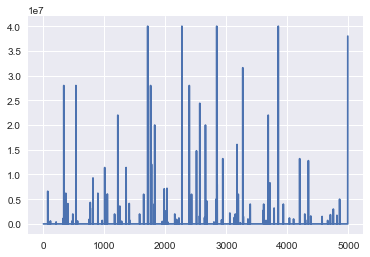

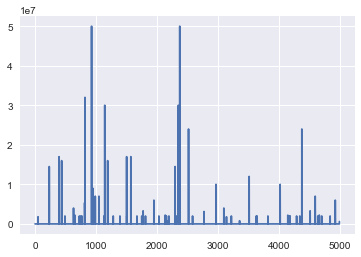

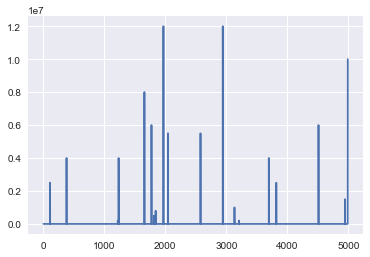

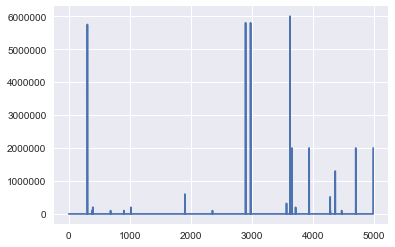

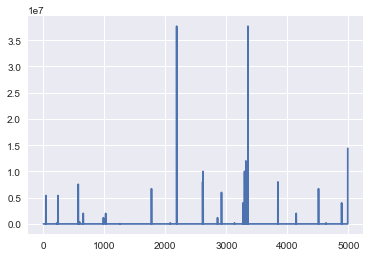

In [202]:
for i in range(5):
    y = train.drop("ID", axis=1).loc[i].sort_index().values
    x = np.arange(len(y))

    plt.plot(x, y)
    plt.show()

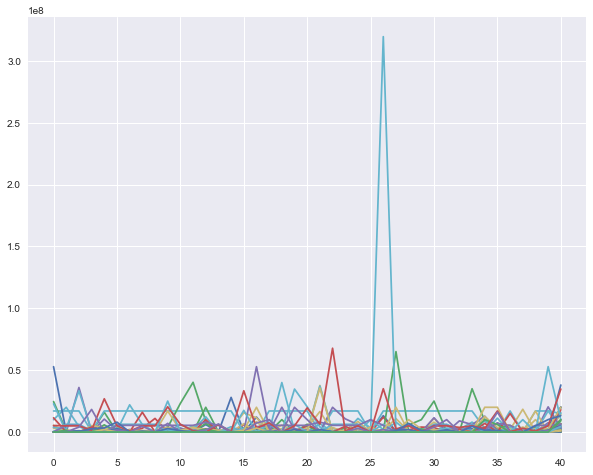

In [209]:
selected_features = sorted([
    'f190486d6', 'c47340d97', 'eeb9cd3aa', '66ace2992', 'e176a204a',
    '491b9ee45', '1db387535', 'c5a231d81', '0572565c2', '024c577b9',
    '15ace8c9f', '23310aa6f', '9fd594eec', '58e2e02e6', '91f701ba2',
    'adb64ff71', '2ec5b290f', '703885424', '26fc93eb7', '6619d81fc',
    '0ff32eb98', '70feb1494', '58e056e12', '1931ccfdd', '1702b5bf0',
    '58232a6fb', '963a49cdc', 'fc99f9426', '241f0f867', '5c6487af1',
    '62e59a501', 'f74e8f13d', 'fb49e4212', '190db8488', '324921c7b',
    'b43a7cfd5', '9306da53f', 'd6bb78916', 'fb0f5dbfe', '6eef030c1',
    "target"
])

plt.figure(figsize=(10, 8))
for i in range(50):
    y = train[selected_features].loc[i].sort_index().values
    x = np.arange(len(y))

    plt.plot(x, y)
plt.show()

## target_str head & tail

In [64]:
def split_target_str(target_str):
    for i, tok in enumerate(reversed(target_str)):
        if tok not in "0.":
            break
    if i == 0:
        return (target_str, "")
    return (target_str[:-i], target_str[-i:])


for target in (
    "100.00", "500.00", "250.00", "266.66", "40000.00"
):
    print(split_target_str(target))


('1', '00.00')
('5', '00.00')
('25', '0.00')
('266.66', '')
('4', '0000.00')


In [165]:
train_id.head()

,ID,target,int_id,target_str,target_split,target_p0,target_p1,target_len0,target_len1
0,000d6aaf2,38000000.0,14068466,38000000.0,"(38, 000000.0)",38,000000.0,2,8
1,000fbd867,600000.0,16504935,600000.0,"(6, 00000.0)",6,00000.0,1,7
2,0027d6b71,10000000.0,41773937,10000000.0,"(1, 0000000.0)",1,0000000.0,1,9
3,0028cbf45,2000000.0,42778437,2000000.0,"(2, 000000.0)",2,000000.0,1,8
4,002a68644,14400000.0,44467780,14400000.0,"(144, 00000.0)",144,00000.0,3,7


In [167]:
train_id[train_id.target_len0 == 2].target_p0.value_counts().sort_index()

11    36
12    72
13    22
14    59
15    63
16    63
17    14
18    48
19    16
21    10
22    30
23     7
24    37
25    42
26    23
27     6
28    29
29    10
31    11
32    29
33     9
34    17
35    27
36    33
37     6
38    11
39     8
41    10
42    16
43     5
      ..
65     9
66     5
67     3
68    13
69     3
71     3
72     7
73     3
74     6
75    11
76     8
77     6
78     5
79     2
81     2
82    11
83     3
84     5
85     9
86     6
88     7
89     3
91     4
92     3
93     2
94     6
95     4
96     1
97     5
98    10
Name: target_p0, Length: 79, dtype: int64

In [78]:
train_id.target_len0.value_counts().sort_index()

1     1952
2     1120
3      576
4      296
5      130
6       18
7        2
8       21
9       78
10     186
11      80
Name: target_len0, dtype: int64

In [76]:
train_id.target_p1.value_counts().sort_index()

              366
.0              2
0.0             7
00.0          102
000.0         616
0000.0        704
00000.0      1176
000000.0     1052
0000000.0     434
Name: target_p1, dtype: int64

In [79]:
train_id.groupby(["target_len0", "target_p1"]).size().sort_index()

target_len0  target_p1
1            0000.0       140
             00000.0      531
             000000.0     847
             0000000.0    434
2            000.0        118
             0000.0       274
             00000.0      523
             000000.0     205
3            00.0           7
             000.0        217
             0000.0       230
             00000.0      122
4            00.0          22
             000.0        214
             0000.0        60
5            0.0            4
             00.0          59
             000.0         67
6            .0             1
             0.0            3
             00.0          14
7                           1
             .0             1
8                          21
9                          78
10                        186
11                         80
dtype: int64

## train & val

In [127]:
train_id.head()

,ID,target,int_id,target_str,target_split,target_p0,target_p1,target_len0,target_len1
0,000d6aaf2,38000000.0,14068466,38000000.0,"(38, 000000.0)",38,000000.0,2,8
1,000fbd867,600000.0,16504935,600000.0,"(6, 00000.0)",6,00000.0,1,7
2,0027d6b71,10000000.0,41773937,10000000.0,"(1, 0000000.0)",1,0000000.0,1,9
3,0028cbf45,2000000.0,42778437,2000000.0,"(2, 000000.0)",2,000000.0,1,8
4,002a68644,14400000.0,44467780,14400000.0,"(144, 00000.0)",144,00000.0,3,7


In [121]:
train_set = train_id[train_id.int_id < 50000000000].ID.values
val_set = train_id[train_id.int_id >= 50000000000].ID.values
print("train-shape:{}, val-shape:{}".format(train_set.shape, val_set.shape))

train-shape:(3197,), val-shape:(1262,)


In [128]:
data_train = train[train.ID.isin(train_set)]
data_val = train[train.ID.isin(val_set)]

ydata_train = train_id[train_id.ID.isin(train_set)]
ydata_val = train_id[train_id.ID.isin(val_set)]

In [125]:
raw_features = [col_ for col_ in train_train.columns if col_ not in {"ID", "target"}]

In [168]:
selected_features = [
    'f190486d6', 'c47340d97', 'eeb9cd3aa', '66ace2992', 'e176a204a',
    '491b9ee45', '1db387535', 'c5a231d81', '0572565c2', '024c577b9',
    '15ace8c9f', '23310aa6f', '9fd594eec', '58e2e02e6', '91f701ba2',
    'adb64ff71', '2ec5b290f', '703885424', '26fc93eb7', '6619d81fc',
    '0ff32eb98', '70feb1494', '58e056e12', '1931ccfdd', '1702b5bf0',
    '58232a6fb', '963a49cdc', 'fc99f9426', '241f0f867', '5c6487af1',
    '62e59a501', 'f74e8f13d', 'fb49e4212', '190db8488', '324921c7b',
    'b43a7cfd5', '9306da53f', 'd6bb78916', 'fb0f5dbfe', '6eef030c1'
]

## lightgbm  -head-len

In [169]:
X_train = data_train[selected_features].values
X_val = data_val[selected_features].values

y_train = ydata_train.target_len0.values 
y_val = ydata_val.target_len0.values

lgb_params = {
    'objective': 'regression',
    'num_leaves': 60,
    'subsample': 0.6143,
    'colsample_bytree': 0.6453,
    'min_split_gain': np.power(10, -2.5988),
    'reg_alpha': np.power(10, -2.2887),
    'reg_lambda': np.power(10, 1.7570),
    'min_child_weight': np.power(10, -0.1477),
    'verbose': -1,
    'seed': 11,
    'boosting_type': 'gbdt',
    'max_depth': 8,
    'learning_rate': 0.03,
    "n_estimators": 1000,
    'metric': 'l1',   
}

lgb_rgr = LightGBMRGWrapper(lgb.LGBMRegressor, seed=0, params=lgb_params)
%time lgb_rgr.train(X_train, y_train)

pred_train = lgb_rgr.predict(X_train)
pred_val = lgb_rgr.predict(X_val)

Wall time: 1.3 s


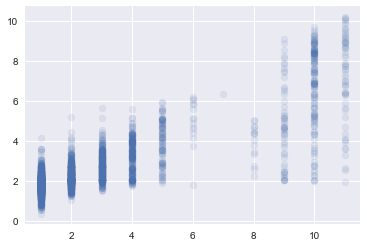

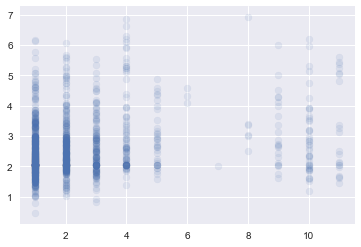

In [170]:
plt.scatter(y_train, pred_train, alpha=.1)
plt.show()

plt.scatter(y_val, pred_val, alpha=.1)
plt.show()

## lightgbm -tail-len

In [181]:
X_train = data_train[selected_features].values
X_val = data_val[selected_features].values

y_train = ydata_train.target_len1.values 
y_val = ydata_val.target_len1.values

lgb_params = {
    'objective': 'regression',
    'num_leaves': 60,
    # 'subsample': 0.6143,
    # 'colsample_bytree': 0.6453,
    # 'min_split_gain': np.power(10, -2.5988),
    # 'reg_alpha': np.power(10, -2.2887),
    # 'reg_lambda': np.power(10, 1.7570),
    # 'min_child_weight': np.power(10, -0.1477),
    'verbose': -1,
    'seed': 11,
    'boosting_type': 'gbdt',
    'max_depth': 8,
    'learning_rate': 0.05,
    "n_estimators": 200,
    'metric': 'l2',   
}

lgb_rgr = LightGBMRGWrapper(lgb.LGBMRegressor, seed=0, params=lgb_params)
%time lgb_rgr.train(X_train, y_train)

pred_train = lgb_rgr.predict(X_train)
pred_val = lgb_rgr.predict(X_val)

Wall time: 386 ms


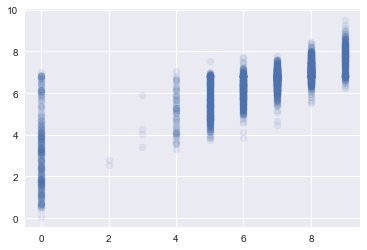

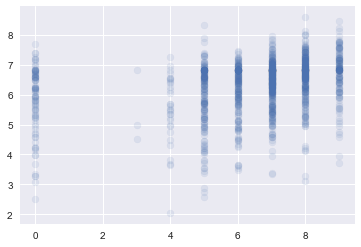

In [182]:
plt.scatter(y_train, pred_train, alpha=.1)
plt.show()

plt.scatter(y_val, pred_val, alpha=.1)
plt.show()

## modify submission

In [183]:
submission_kernel = pd.read_csv("./result/reduced_set_submission.csv")
submission_kernel.head()

,ID,target
0,000137c73,2.941939e+06
1,00021489f,9.160367e+05
2,0004d7953,1.439516e+06
3,00056a333,5.751728e+06
4,00056d8eb,2.003607e+06


In [188]:
def modify(target_int_str):
    for i in range(1, len(target_int_str)):
        if target_int_str[i] == "0":
            return target_int_str[:i] + "0" * (len(target_int_str) - i)
    return target_int_str

for tar in (
    "3033",
    "44044",
    "555055",
):
    print(modify(tar))

3000
44000
555000


In [192]:
submission_kernel["target"] = submission_kernel.target.astype("int").astype("str").apply(modify)
submission_kernel.to_csv("./result/submission-002-modify0.csv", index=False)

In [246]:
def modify1(target_int_str):
    for i in range(1, len(target_int_str)):
        if target_int_str[i] == "0":
            return target_int_str[:i] + "0" * (len(target_int_str) - i)
        if i + 1 < len(target_int_str) and target_int_str[i] == "9" and target_int_str[i+1] == "9":
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "9" and int(target_int_str[i+1]) >= 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 4 < i + 1 < len(target_int_str) and target_int_str[i] == "1" and target_int_str[i+1] == "0":
            return str(int(target_int_str[:i]) - 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) > 7:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
        if 5 < i + 1 < len(target_int_str) and int(target_int_str[i+1]) < 3:
            return str(int(target_int_str[:i]) + 1) + "0" * (len(target_int_str) - i)
    return target_int_str

submission_kernel["target"] = submission_kernel.target.astype("int").astype("str").apply(modify1)
submission_kernel.to_csv("./result/submission-002-modify1.csv", index=False)